# ✈️ Sentiment Analysis on US Airline Tweets
This project performs sentiment analysis using both **VADER** (rule-based) and **RoBERTa** (transformer-based) models.

We use the publicly available **Twitter US Airline Sentiment Dataset** to:
- Preprocess and clean tweet data
- Apply VADER sentiment scoring
- Apply RoBERTa sentiment classification
- Compare model accuracy
- Extract business insights from sentiment trends

## 1 Import Required Libraries

In [ ]:
!pip install nrclex

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=87da0a8d6226d13234850db99d4ccfcc6d9c4f8ad0632a8f56d5234b7557b67f
  Stored in directory: /root/.cache/pip/wheels/ed/ac/fa/7afddefd14f51c4a963ed291b9052746ed3929473e5a33118d
Successfully built nrclex


In [ ]:
from nrclex import NRCLex

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from wordcloud import WordCloud
from nrclex import NRCLex

nltk.download('vader_lexicon')
sns.set(style='whitegrid')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2 Load the Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [ ]:
# Load the uploaded CSV
df = pd.read_csv('Tweets.csv')

# Select relevant columns
df = df[['text', 'airline_sentiment', 'airline', 'negativereason']]

# Drop rows with missing text
df.dropna(subset=['text'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Display top 5 rows
df.head()

,text,airline_sentiment,airline,negativereason
0,@VirginAmerica What @dhepburn said.,neutral,Virgin America,NaN
1,@VirginAmerica plus you've added commercials t...,positive,Virgin America,NaN
2,@VirginAmerica I didn't today... Must mean I n...,neutral,Virgin America,NaN
3,@VirginAmerica it's really aggressive to blast...,negative,Virgin America,Bad Flight
4,@VirginAmerica and it's a really big bad thing...,negative,Virgin America,Can't Tell


## 3 Clean the Text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)            # remove mentions
    text = re.sub(r"#\w+", "", text)            # remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)        # remove special characters
    text = re.sub(r"\s+", " ", text).strip()    # normalize whitespace
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()

,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it


## 5 Sentiment Distribution

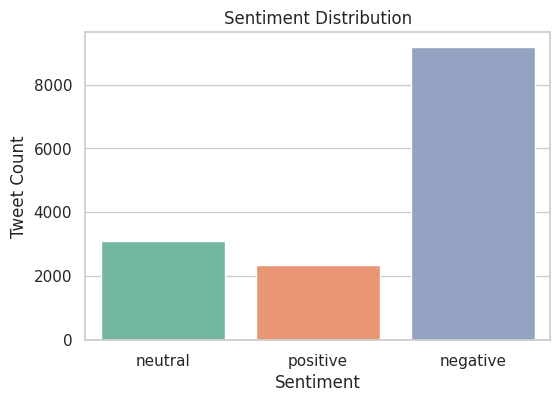

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='airline_sentiment', data=df, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()

## 6 Sentiment by Airline

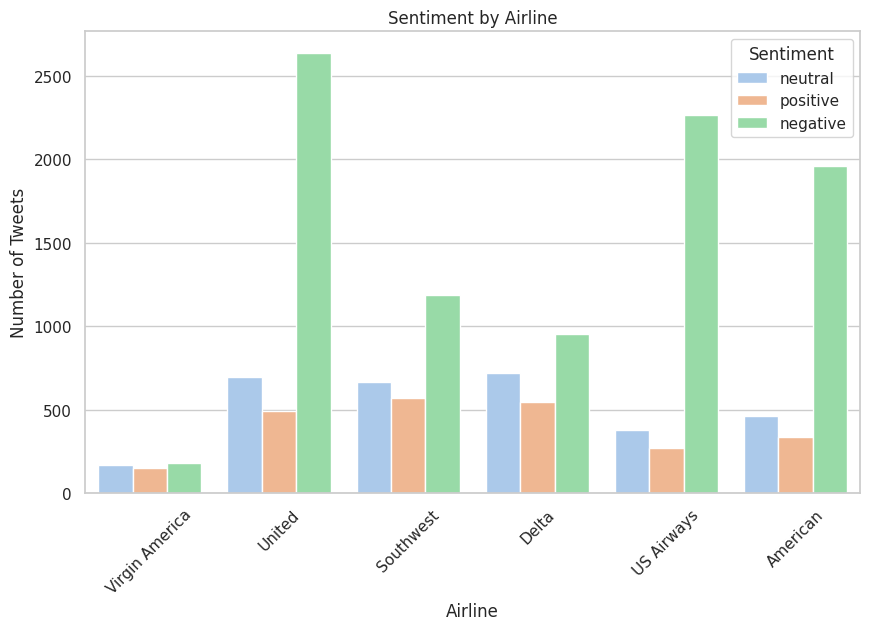

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='airline', hue='airline_sentiment', data=df, palette='pastel')
plt.title('Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

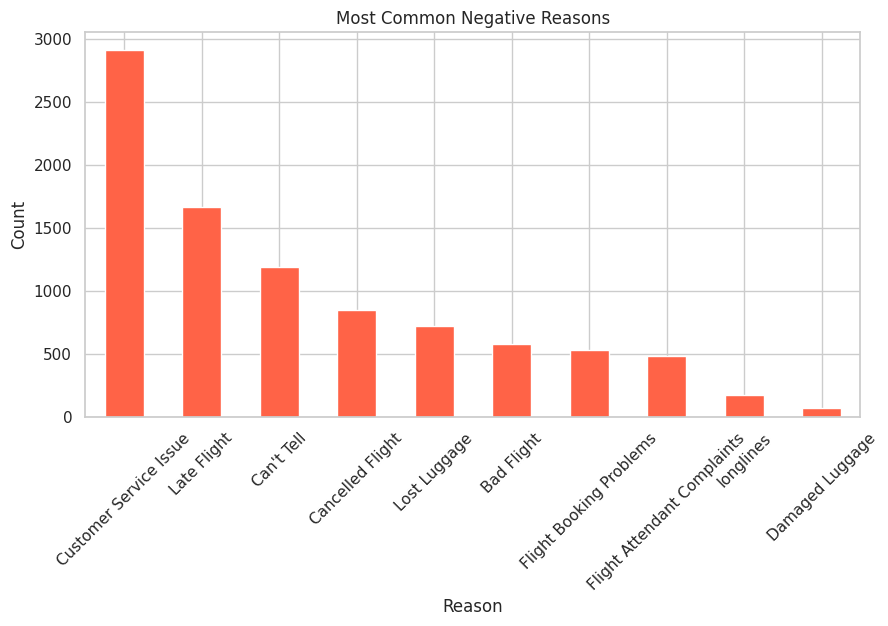

In [ ]:
plt.figure(figsize=(10, 5))
df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts().plot(kind='bar', color='tomato')
plt.title('Most Common Negative Reasons')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


## 7 Word Clouds by Sentiment

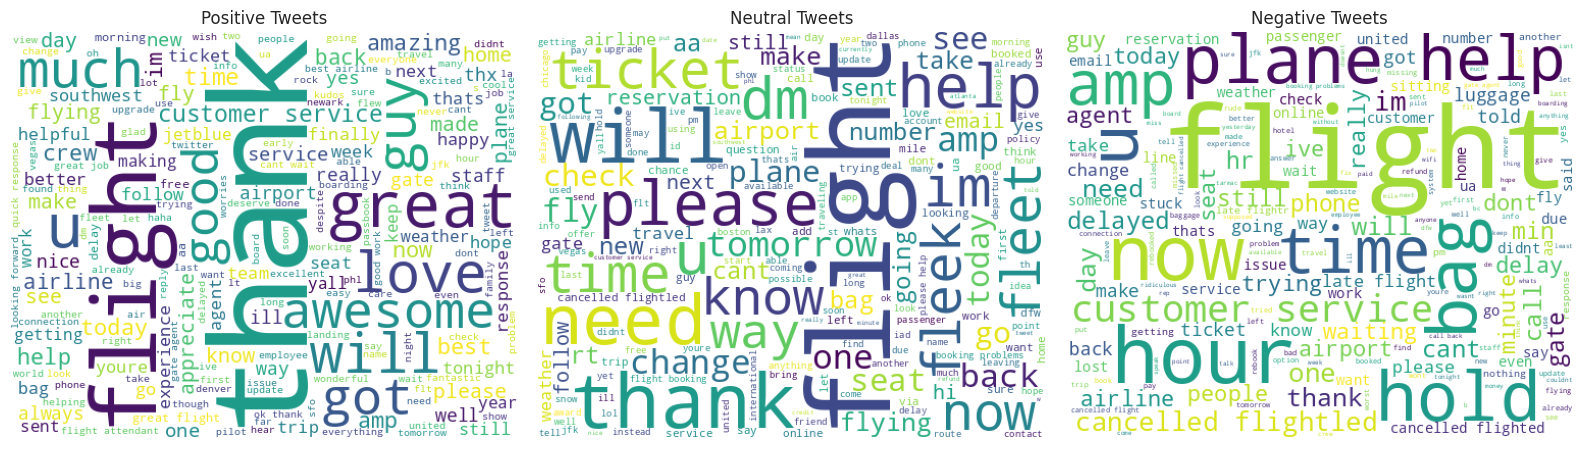

In [ ]:
positive_text = ' '.join(df[df['airline_sentiment'] == 'positive']['clean_text'])
negative_text = ' '.join(df[df['airline_sentiment'] == 'negative']['clean_text'])
neutral_text = ' '.join(df[df['airline_sentiment'] == 'neutral']['clean_text'])

plt.figure(figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(WordCloud(width=500, height=400, background_color='white').generate(positive_text))
plt.title("Positive Tweets")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(WordCloud(width=500, height=400, background_color='white').generate(neutral_text))
plt.title("Neutral Tweets")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(WordCloud(width=500, height=400, background_color='white').generate(negative_text))
plt.title("Negative Tweets")
plt.axis('off')

plt.tight_layout()
plt.show()


## 8 Initialize the VADER Sentiment Analyzer

In [ ]:
# Initialize VADER
sid = SentimentIntensityAnalyzer()

## 8.1 Get Sentiment Scores for Each Tweet

In [ ]:
# Apply VADER on clean text
df['vader_scores'] = df['clean_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Map compound score to sentiment
def get_vader_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_scores'].apply(get_vader_sentiment)
df[['clean_text', 'vader_scores', 'vader_sentiment']].head()


,clean_text,vader_scores,vader_sentiment
0,what said,0.0000,neutral
1,plus youve added commercials to the experience...,0.0000,neutral
2,i didnt today must mean i need to take another...,0.0000,neutral
3,its really aggressive to blast obnoxious enter...,-0.2716,negative
4,and its a really big bad thing about it,-0.5829,negative


## 8.2 Compare VADER with Original Labels

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("VADER vs Original Sentiment Accuracy:")
print(accuracy_score(df['airline_sentiment'], df['vader_sentiment']))

print("\nClassification Report:")
print(classification_report(df['airline_sentiment'], df['vader_sentiment']))

VADER vs Original Sentiment Accuracy:
0.5398907103825137

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.50      0.64      9178
     neutral       0.38      0.43      0.40      3099
    positive       0.33      0.86      0.48      2363

    accuracy                           0.54     14640
   macro avg       0.54      0.59      0.51     14640
weighted avg       0.70      0.54      0.56     14640



## 9 Load the Pretrained RoBERTa Model

In [ ]:
# Load sentiment analysis pipeline using RoBERTa
roberta_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


## 9.1 Apply RoBERTa to Tweets

In [ ]:
# Apply to a subset (can increase if needed)
sample_df = df.head(500).copy()

# Get predictions
sample_df['roberta_result'] = sample_df['clean_text'].apply(lambda x: roberta_classifier(x)[0])
sample_df['roberta_label'] = sample_df['roberta_result'].apply(lambda x: x['label'].lower())
sample_df['roberta_score'] = sample_df['roberta_result'].apply(lambda x: x['score'])

sample_df[['clean_text', 'roberta_label', 'roberta_score']].head()

,clean_text,roberta_label,roberta_score
0,what said,label_1,0.564481
1,plus youve added commercials to the experience...,label_0,0.600193
2,i didnt today must mean i need to take another...,label_1,0.610744
3,its really aggressive to blast obnoxious enter...,label_0,0.921632
4,and its a really big bad thing about it,label_0,0.898205


## 9.2 Evaluate RoBERTa vs Original Sentiment

In [ ]:
print("RoBERTa vs Original Sentiment Accuracy:")
print(accuracy_score(sample_df['airline_sentiment'], sample_df['roberta_label']))

print("\nClassification Report:")
print(classification_report(sample_df['airline_sentiment'], sample_df['roberta_label']))

RoBERTa vs Original Sentiment Accuracy:
0.0

Classification Report:
              precision    recall  f1-score   support

     label_0       0.00      0.00      0.00       0.0
     label_1       0.00      0.00      0.00       0.0
     label_2       0.00      0.00      0.00       0.0
    negative       0.00      0.00      0.00     181.0
     neutral       0.00      0.00      0.00     168.0
    positive       0.00      0.00      0.00     151.0

    accuracy                           0.00     500.0
   macro avg       0.00      0.00      0.00     500.0
weighted avg       0.00      0.00      0.00     500.0



## 10 Apply NRCLex for Emotion Extraction

In [ ]:
import nltk
nltk.download('punkt_tab')
def get_emotions(text):
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

df['emotions'] = df['clean_text'].apply(get_emotions)
df['emotions'].head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,emotions
0,{}
1,{}
2,{'surprise': 1}
3,"{'anger': 3, 'fear': 2, 'negative': 3, 'surpri..."
4,"{'anger': 1, 'disgust': 1, 'fear': 1, 'negativ..."


## 10.1 Convert Emotion Dictionary to DataFrame

In [ ]:
# Convert list of emotion dicts to a DataFrame
emotion_df = pd.json_normalize(df['emotions'])

# Replace NaN with 0
emotion_df.fillna(0, inplace=True)

# Add to original DataFrame
df = pd.concat([df, emotion_df], axis=1)
df.head()

,text,airline_sentiment,airline,negativereason,clean_text,vader_score,vader_sentiment,vader_scores,emotions,surprise,anger,fear,negative,disgust,sadness,anticipation,joy,positive,trust
0,@VirginAmerica What @dhepburn said.,neutral,Virgin America,NaN,what said,0.0000,neutral,0.0000,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,@VirginAmerica plus you've added commercials t...,positive,Virgin America,NaN,plus youve added commercials to the experience...,0.0000,neutral,0.0000,{},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,@VirginAmerica I didn't today... Must mean I n...,neutral,Virgin America,NaN,i didnt today must mean i need to take another...,0.0000,neutral,0.0000,{'surprise': 1},1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,@VirginAmerica it's really aggressive to blast...,negative,Virgin America,Bad Flight,its really aggressive to blast obnoxious enter...,-0.5984,negative,-0.2716,"{'anger': 3, 'fear': 2, 'negative': 3, 'surpri...",2.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
4,@VirginAmerica and it's a really big bad thing...,negative,Virgin America,Can't Tell,and its a really big bad thing about it,-0.5829,negative,-0.5829,"{'anger': 1, 'disgust': 1, 'fear': 1, 'negativ...",0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


## 10.2 Plot Overall Emotion Distribution

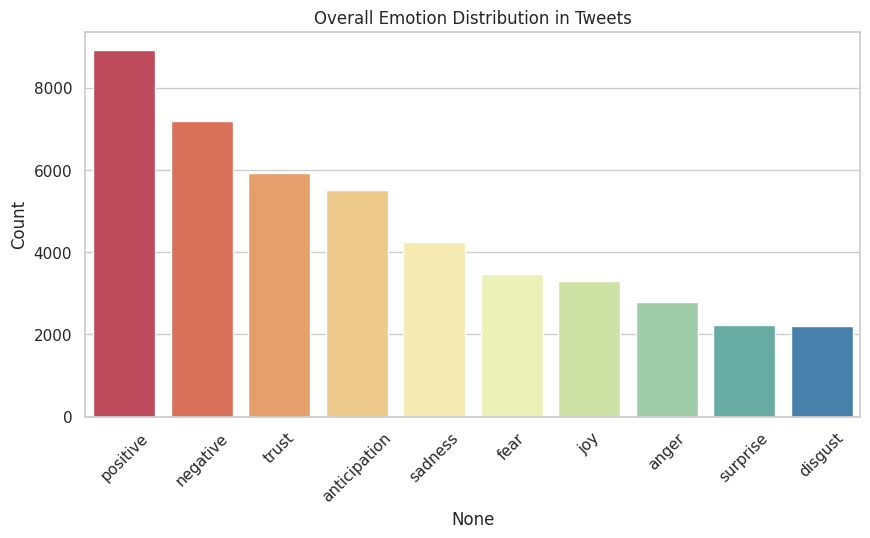

In [ ]:
emotion_totals = emotion_df.sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=emotion_totals.index, y=emotion_totals.values, palette='Spectral')
plt.title("Overall Emotion Distribution in Tweets")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## 11 Extract Most Common Keywords

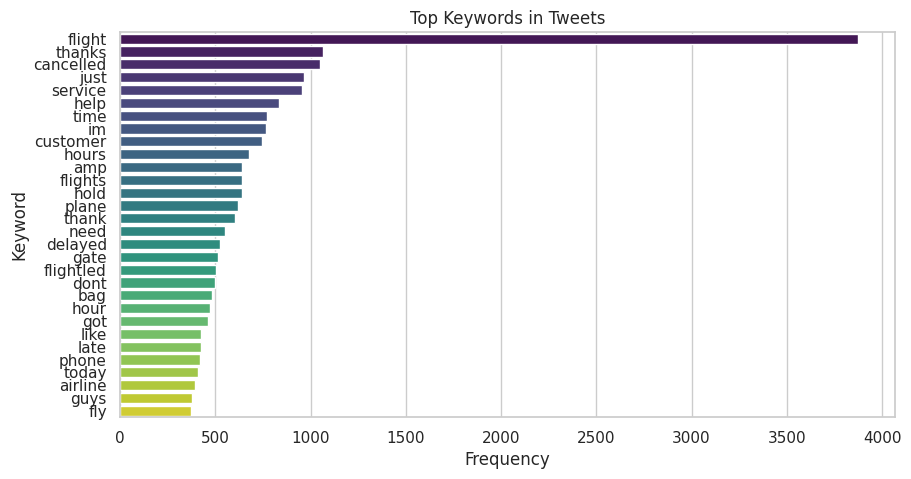

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=30)
X = cv.fit_transform(df['clean_text'])

# Get top keywords
keywords = pd.DataFrame(cv.get_feature_names_out(), columns=['Keyword'])
keywords['Frequency'] = X.toarray().sum(axis=0)
keywords.sort_values(by='Frequency', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Frequency', y='Keyword', data=keywords, palette='viridis')
plt.title("Top Keywords in Tweets")
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.show()

## 11.1.1 Vectorize Tweets for LDA

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizer for LDA (no max_features to preserve topics)
lda_vectorizer = CountVectorizer(stop_words='english')
X_lda = lda_vectorizer.fit_transform(df['clean_text'])

## 11.1.2 Apply LDA to Discover Topics

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Train LDA with 5 topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X_lda)

LatentDirichletAllocation(n_components=5, random_state=42)

## 11.1.3 Display Top Keywords per Topic

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n🧠 Topic #{topic_idx + 1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda_model, lda_vectorizer.get_feature_names_out(), 10)


## 11.1.4 Assign Dominant Topic to Each Tweet (Optional)

In [ ]:
# Assign dominant topic to each tweet
df['lda_topic'] = lda_model.transform(X_lda).argmax(axis=1)
df[['clean_text', 'lda_topic']].head()

In [ ]:
vader = SentimentIntensityAnalyzer()
df['vader_score'] = df['text'].apply(lambda x: vader.polarity_scores(x)['compound'])

def classify_vader(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_score'].apply(classify_vader)

In [ ]:

roberta_pipeline = pipeline('sentiment-analysis')
df_sample = df.sample(1000, random_state=42).copy()
roberta_results = roberta_pipeline(df_sample['text'].tolist(), truncation=True)
df_sample['roberta_label'] = [res['label'].lower() for res in roberta_results]

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


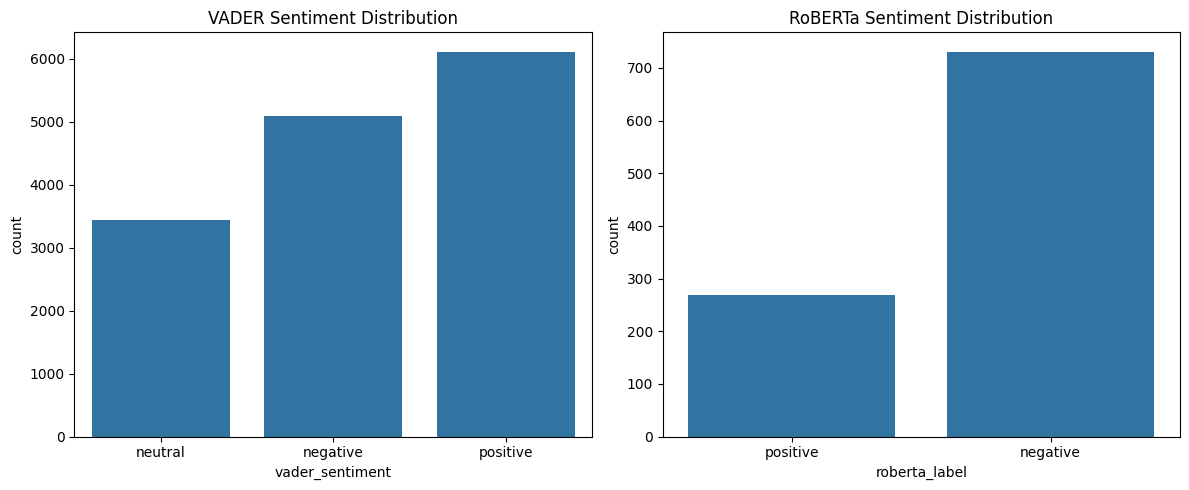

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='vader_sentiment', data=df)
plt.title('VADER Sentiment Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='roberta_label', data=df_sample)
plt.title('RoBERTa Sentiment Distribution')
plt.tight_layout()
plt.show()

In [ ]:
vader_accuracy = (df['vader_sentiment'] == df['airline_sentiment']).mean()
roberta_accuracy = (df_sample['roberta_label'] == df_sample['airline_sentiment']).mean()
print(f"VADER Accuracy: {vader_accuracy:.2%}")
print(f"RoBERTa Accuracy: {roberta_accuracy:.2%}")

VADER Accuracy: 54.28%
RoBERTa Accuracy: 70.10%


In [ ]:
top_neg_reasons = df[df['airline_sentiment'] == 'negative']['negativereason'].value_counts().head(5)
print("Top 5 reasons for negative sentiment:")
print(top_neg_reasons)

Top 5 reasons for negative sentiment:
negativereason
Customer Service Issue    2910
Late Flight               1665
Can't Tell                1190
Cancelled Flight           847
Lost Luggage               724
Name: count, dtype: int64
